# Table of contents
***

* [1. Introduction](#1)
* [2. Data set review & preparation](#2)
* [3. Exploratory Data Analysis](#3)
* [4. Model fitting and selection](#4)
* [5. Conclusion](#5)


# <font color="#00bfff"> 1. Introduction </font>
<a id="1"></a> 
***

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from plotly import tools
import matplotlib.pyplot as plt
# import plotly.plotly as py
# import plotly.figure_factory as ff
# import plotly.graph_objs as go
# from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# init_notebook_mode(connected=True)
df = pd.read_csv('../input/bank-data-set/bank.csv')

df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1.0,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1.0,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1.0,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1.0,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1.0,0,unknown,yes


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        11162 non-null  int64  
 1   job        11162 non-null  object 
 2   marital    11162 non-null  object 
 3   education  11162 non-null  object 
 4   default    11162 non-null  object 
 5   balance    11162 non-null  int64  
 6   housing    11162 non-null  object 
 7   loan       11162 non-null  object 
 8   contact    11162 non-null  object 
 9   day        11162 non-null  int64  
 10  month      11162 non-null  object 
 11  duration   11162 non-null  int64  
 12  campaign   11162 non-null  int64  
 13  pdays      11155 non-null  float64
 14  previous   11162 non-null  int64  
 15  poutcome   11162 non-null  object 
 16  deposit    11162 non-null  object 
dtypes: float64(1), int64(6), object(10)
memory usage: 1.4+ MB


# Attributes Description:

1 - **age:** (numeric)<br>
2 - **job:** type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')<br>
3 - **marital:** marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)<br>
4 - **education:** (categorical: primary, secondary, tertiary and unknown)<br>
5 - **default:** has credit in default? (categorical: 'no','yes','unknown')<br>
6 - **housing:** has housing loan? (categorical: 'no','yes','unknown')<br>
7 - **loan:** has personal loan? (categorical: 'no','yes','unknown')<br>
8 - **balance:** Balance of the individual.

8 - **contact:** contact communication type (categorical: 'cellular','telephone') <br>
9 - **month:** last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')<br>
10 - **day:** last contact day of the week (categorical: 'mon','tue','wed','thu','fri')<br>
11 - **duration:** last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.<br>

12 - **campaign:** number of contacts performed during this campaign and for this client (numeric, includes last contact)<br>
13 - **pdays:** number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)<br>
14 - **previous:** number of contacts performed before this campaign and for this client (numeric)<br>
15 - **poutcome:** outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')<br>

Output variable (desired target):<br>
21 - **y** - has the client subscribed a term deposit? (binary: 'yes','no')

# <font color="#00bfff"> 2. Data set review & preparation
<a id="2"></a> 
***

In [3]:
#Date cleaning
#Missing value 
missing_values_count = df.isnull().sum()
missing_values_count

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        7
previous     0
poutcome     0
deposit      0
dtype: int64

By looking at the documentation, I can see that pdays has missed some information, but all other information are intact. This means that these values are probably missing because they were not recorded, rather than because they don't exist. So, it would make sense for us to try and guess what they should be rather than just leaving them as NA's.

In [4]:
pdays_median = df['pdays'].median()
pdays_mean = df['pdays'].mean()
print('mean',round(pdays_mean,2))
print('median',pdays_median)

mean 51.36
median -1.0


In [5]:
# How many total missing values do we have?
total_cells = np.product(df.shape)
total_missing = missing_values_count.sum()

# Percent of data that is missing
percent_missing = (total_missing/total_cells) * 100
print(round(percent_missing * 100,2), '%')

0.37 %


In [6]:
# The missing value accounts for 0.37%, I would like to use median to fill the missing part.
df = df.fillna(pdays_median)
term_deposits = df.copy()

In [7]:
# No more missing value
missing_values_count = df.isnull().sum()
missing_values_count 

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

# <font color="#00bfff"> 3. Exploratory Data Analysis
<a id="3"></a> 
***

In [8]:
# Get list of categorical variables
s = (df.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'deposit']


In [9]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1.0,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1.0,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1.0,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1.0,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1.0,0,unknown,yes


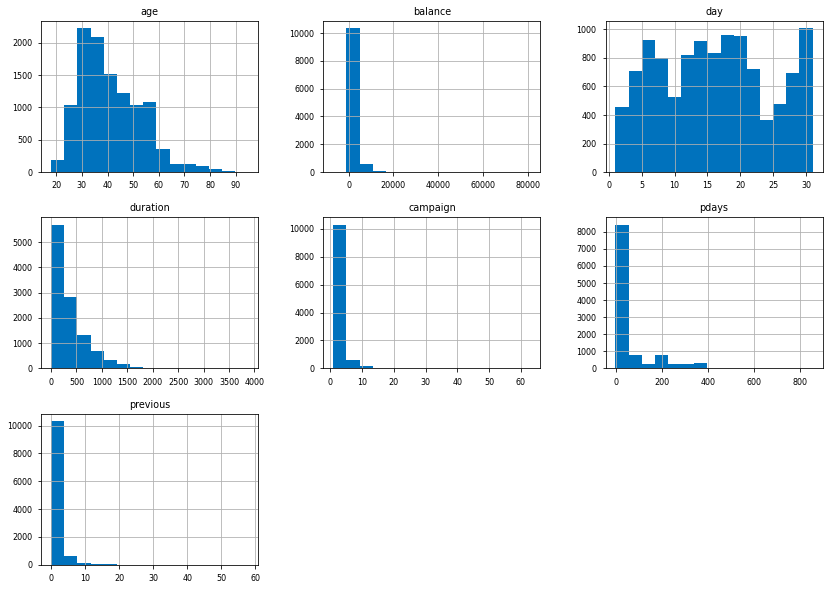

In [10]:
# Let's see how the numeric data is distributed.
plt.style.use('seaborn-paper')
df.hist(bins=15, figsize=(14,10), color='#0072BD')
plt.show()

In [11]:
df.deposit = df.deposit.map({'no':0, 'yes':1}).astype('uint8')

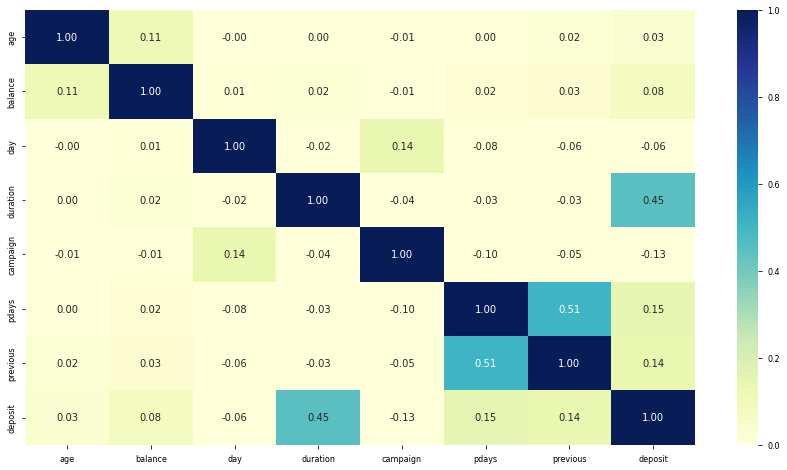

In [12]:
#correlation matrix
plt.figure(figsize=(15,8))
sns.heatmap(df.corr(), cmap="YlGnBu",annot=True, fmt='.2f', vmin=0);

* most correlated with target feature is call duration. So we need to transform it to reduce the influence
* higly correlated features (pdays and previous) may describe the relationship between campaign and client contact from different angles. Their variance might support model capacity for generalization.

<h3> Analysis by Job: </h3>


In [13]:
# Build a function to show categorical values disribution
def plot_bar(column):
    # temp df 
    temp_1 = pd.DataFrame()
    # count categorical values
    temp_1['No_deposit'] = term_deposits[term_deposits['deposit'] == 'no'][column].value_counts()
    temp_1['Yes_deposit'] = term_deposits[term_deposits['deposit'] == 'yes'][column].value_counts()
    temp_1.plot(kind='bar',stacked=True)
    plt.xlabel(f'{column}')
    plt.ylabel('Number of clients')
    plt.title('Distribution of {} and deposit'.format(column))
    plt.show();

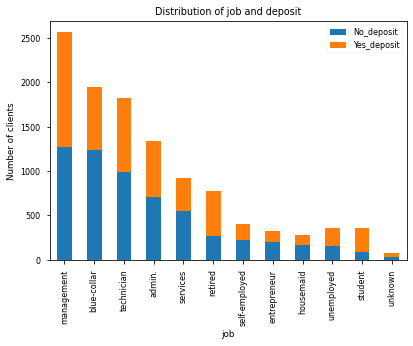

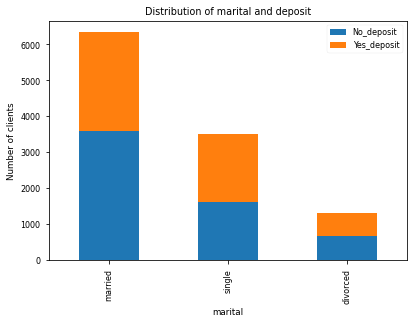

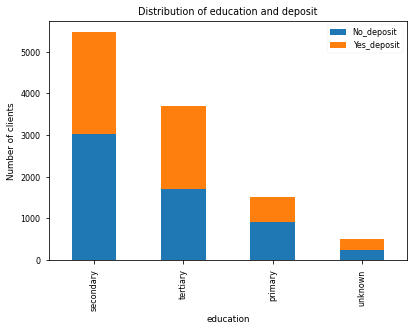

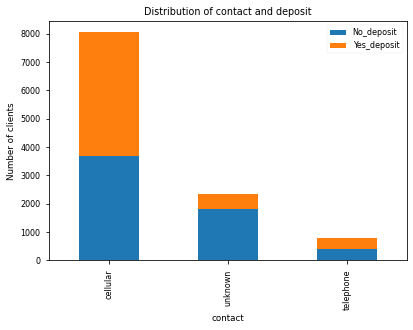

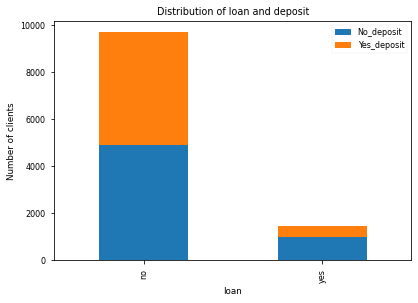

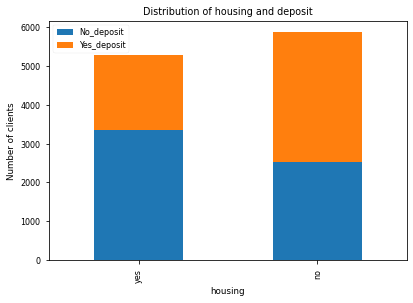

(None, None, None, None, None, None)

In [14]:
plot_bar('job'), plot_bar('marital'), plot_bar('education'), plot_bar('contact'), plot_bar('loan'), plot_bar('housing')

* Administrative staff and technical specialists opened the deposit most of all. In relative terms, a high proportion of pensioners and students might be mentioned as well.
* Best communication channel is secullar.
* The difference is evident between consumers who already use the services of banks and received a loan.
* Home ownership does affect marketing company performance.

<h3> Campaign Duration: </h3>

**outlier**

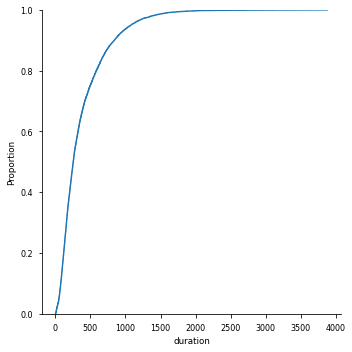

In [15]:
sns.displot(df['duration'],kind="ecdf")

The average campaign duration is 374.76, I think the outlier above 3500 should be excluded.  Long dial's holding time and frequently change receptionist maybe the reason that outlier duration value is too large. 

In [16]:
#Remove everything above 99%
term_duration = term_deposits.copy()
term_duration= term_duration.loc[term_duration['duration'] <= np.quantile(term_duration['duration'],q=0.99)]

In [17]:
import plotly.express as px

fig = px.box(term_duration, x="job", y="duration",color="deposit")
fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
fig.show()

* The leads who have not made a deposit have lesser duration on calls
* Comparing the average, the blue collar, entrepreneur have high duration in calls and student, retired have less duration in average
* Large distribution of leads were from self employed clients and management people.

# <font color="#00bfff"> 4. Model fitting and selection
<a id="4"></a> 
***

## Stratified Sampling: 

In [18]:
from sklearn.model_selection import StratifiedShuffleSplit
# Here we split the data into training and test sets and implement a stratified shuffle split.
stratified = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_set, test_set in stratified.split(df, df["loan"]):
    stratified_train = df.loc[train_set]
    stratified_test = df.loc[test_set]
    
stratified_train["loan"].value_counts()/len(df)
stratified_test["loan"].value_counts()/len(df)

no     0.173894
yes    0.026160
Name: loan, dtype: float64

In [19]:
# Separate the labels and the features.
train_data = stratified_train # Make a copy of the stratified training set.
test_data = stratified_test
train_data.shape
test_data.shape
train_data['deposit'].value_counts()

0    4697
1    4232
Name: deposit, dtype: int64

In [20]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
       
        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [21]:
from sklearn.base import BaseEstimator, TransformerMixin

# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Making pipelines
numerical_pipeline = Pipeline([
    ("select_numeric", DataFrameSelector(["age", "balance", "day", "campaign", "pdays", "previous","duration"])),
    ("std_scaler", StandardScaler()),
])

categorical_pipeline = Pipeline([
    ("select_cat", DataFrameSelector(["job", "education", "marital", "default", "housing", "loan", "contact", "month",
                                     "poutcome"])),
    ("cat_encoder", CategoricalEncoder(encoding='onehot-dense'))
])

from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("numerical_pipeline", numerical_pipeline),
        ("categorical_pipeline", categorical_pipeline),
    ])

In [23]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning:

`np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning:

`np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:59: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `n

array([[ 1.14643868,  1.68761105,  1.69442818, ...,  0.        ,
         0.        ,  1.        ],
       [-0.86102339, -0.35066205, -0.5560058 , ...,  0.        ,
         0.        ,  1.        ],
       [-0.94466765, -0.20504785,  0.39154535, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.86102339, -0.26889658, -1.02978138, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.2263519 , -0.32166951,  0.50998924, ...,  0.        ,
         0.        ,  1.        ],
       [-0.61009063, -0.34740446,  1.69442818, ...,  1.        ,
         0.        ,  0.        ]])

In [24]:
y_train = train_data['deposit']
y_test = test_data['deposit']
y_train.shape

(8929,)

In [25]:
from sklearn.preprocessing import LabelEncoder

encode = LabelEncoder()
y_train = encode.fit_transform(y_train)
y_test = encode.fit_transform(y_test)
y_train_yes = (y_train == 1)
y_train
y_train_yes

array([False, False,  True, ...,  True,  True, False])

In [26]:
some_instance = X_train[1250]

In [27]:
# Time for Classification Models
import time


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB


dict_classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Nearest Neighbors": KNeighborsClassifier(),
    "Linear SVM": SVC(),
    "Gradient Boosting Classifier": GradientBoostingClassifier(),
    "Decision Tree": tree.DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=18),
    "Neural Net": MLPClassifier(alpha=1),
    "Naive Bayes": GaussianNB()
}

In [28]:
#  Thanks to Ahspinar for the function. 
no_classifiers = len(dict_classifiers.keys())

def batch_classify(X_train, Y_train, verbose = True):
    df_results = pd.DataFrame(data=np.zeros(shape=(no_classifiers,3)), columns = ['classifier', 'train_score', 'training_time'])
    count = 0
    for key, classifier in dict_classifiers.items():
        t_start = time.clock()
        classifier.fit(X_train, Y_train)
        t_end = time.clock()
        t_diff = t_end - t_start
        train_score = classifier.score(X_train, Y_train)
        df_results.loc[count,'classifier'] = key
        df_results.loc[count,'train_score'] = train_score
        df_results.loc[count,'training_time'] = t_diff
        if verbose:
            print("trained {c} in {f:.2f} s".format(c=key, f=t_diff))
        count+=1
    return df_results

In [29]:
df_results = batch_classify(X_train, y_train)
print(df_results.sort_values(by='train_score', ascending=False))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning:

time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

t

trained Logistic Regression in 0.96 s
trained Nearest Neighbors in 0.01 s


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning:

time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead



trained Linear SVM in 3.24 s


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning:

time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning:

time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

time.clock has been deprecated in Pyt

trained Gradient Boosting Classifier in 1.89 s
trained Decision Tree in 0.10 s


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning:

time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead



trained Random Forest in 0.26 s
trained Neural Net in 36.71 s
trained Naive Bayes in 0.06 s
                     classifier  train_score  training_time
4                 Decision Tree     1.000000       0.095774
5                 Random Forest     0.997088       0.255264
2                    Linear SVM     0.881958       3.239097
1             Nearest Neighbors     0.863255       0.009630
3  Gradient Boosting Classifier     0.861463       1.886544
6                    Neural Net     0.856983      36.705568
0           Logistic Regression     0.830776       0.957500
7                   Naive Bayes     0.721693       0.064725


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning:

time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning:

time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead



In [30]:
# Use Cross-validation.
from sklearn.model_selection import cross_val_score

# Logistic Regression
log_reg = LogisticRegression()
log_scores = cross_val_score(log_reg, X_train, y_train, cv=3)
log_reg_mean = log_scores.mean()

# SVC
svc_clf = SVC()
svc_scores = cross_val_score(svc_clf, X_train, y_train, cv=3)
svc_mean = svc_scores.mean()

# KNearestNeighbors
knn_clf = KNeighborsClassifier()
knn_scores = cross_val_score(knn_clf, X_train, y_train, cv=3)
knn_mean = knn_scores.mean()

# Decision Tree
tree_clf = tree.DecisionTreeClassifier()
tree_scores = cross_val_score(tree_clf, X_train, y_train, cv=3)
tree_mean = tree_scores.mean()

# Gradient Boosting Classifier
grad_clf = GradientBoostingClassifier()
grad_scores = cross_val_score(grad_clf, X_train, y_train, cv=3)
grad_mean = grad_scores.mean()

# Random Forest Classifier
rand_clf = RandomForestClassifier(n_estimators=18)
rand_scores = cross_val_score(rand_clf, X_train, y_train, cv=3)
rand_mean = rand_scores.mean()

# NeuralNet Classifier
neural_clf = MLPClassifier(alpha=1)
neural_scores = cross_val_score(neural_clf, X_train, y_train, cv=3)
neural_mean = neural_scores.mean()

# Naives Bayes
nav_clf = GaussianNB()
nav_scores = cross_val_score(nav_clf, X_train, y_train, cv=3)
nav_mean = neural_scores.mean()

# Create a Dataframe with the results.
d = {'Classifiers': ['Logistic Reg.', 'SVC', 'KNN', 'Dec Tree', 'Grad B CLF', 'Rand FC', 'Neural Classifier', 'Naives Bayes'], 
    'Crossval Mean Scores': [log_reg_mean, svc_mean, knn_mean, tree_mean, grad_mean, rand_mean, neural_mean, nav_mean]}

result_df = pd.DataFrame(data=d)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [31]:
# All our models perform well but I will go with GradientBoosting.
result_df = result_df.sort_values(by=['Crossval Mean Scores'], ascending=False)
result_df

,Classifiers,Crossval Mean Scores
1,SVC,0.851831
6,Neural Classifier,0.846791
7,Naives Bayes,0.846791
4,Grad B CLF,0.844328
5,Rand FC,0.841528
0,Logistic Reg.,0.828536
2,KNN,0.804569
3,Dec Tree,0.785978


In [32]:
# Cross validate our Gradient Boosting Classifier
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(grad_clf, X_train, y_train, cv=3)

In [33]:
from sklearn.metrics import accuracy_score
grad_clf.fit(X_train, y_train)
print ("Gradient Boost Classifier accuracy is %2.2f" % accuracy_score(y_train, y_train_pred))

Gradient Boost Classifier accuracy is 0.84


In [34]:
# Let's find the scores  for precision and recall.
from sklearn.metrics import precision_score, recall_score
# The model is 77% sure that the potential client will suscribe to a term deposit. 
# The model is only retaining 60% of clients that agree to suscribe a term deposit.
print('Precision Score: ', precision_score(y_train, y_train_pred))
# The classifier only detects 60% of potential clients that will suscribe to a term deposit.
print('Recall Score: ', recall_score(y_train, y_train_pred))

Precision Score:  0.8232886058676371
Recall Score:  0.8553875236294896


In [35]:
from sklearn.metrics import f1_score

f1_score(y_train, y_train_pred)

0.8390311739483138

In [36]:
y_scores = grad_clf.decision_function([some_instance])
y_scores

array([-3.65645629])

In [37]:
# Increasing the threshold decreases the recall.
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [38]:
y_scores = cross_val_predict(grad_clf, X_train, y_train, cv=3, method="decision_function")
neural_y_scores = cross_val_predict(neural_clf, X_train, y_train, cv=3, method="predict_proba")
naives_y_scores = cross_val_predict(nav_clf, X_train, y_train, cv=3, method="predict_proba")

In [39]:
# hack to work around issue #9589 introduced in Scikit-Learn 0.19.0
if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]

if neural_y_scores.ndim == 2:
    neural_y_scores = neural_y_scores[:, 1]
    
if naives_y_scores.ndim == 2:
    naives_y_scores = naives_y_scores[:, 1]

In [40]:
y_scores.shape

(8929,)

In [41]:
# How can we decide which threshold to use? We want to return the scores instead of predictions with this code.
from sklearn.metrics import precision_recall_curve

precisions, recalls, threshold = precision_recall_curve(y_train, y_scores)

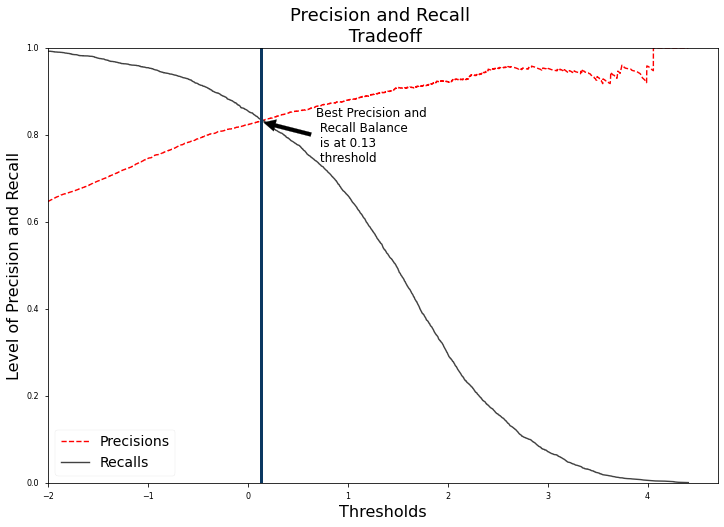

In [42]:
def precision_recall_curve(precisions, recalls, thresholds):
    fig, ax = plt.subplots(figsize=(12,8))
    plt.plot(thresholds, precisions[:-1], "r--", label="Precisions")
    plt.plot(thresholds, recalls[:-1], "#424242", label="Recalls")
    plt.title("Precision and Recall \n Tradeoff", fontsize=18)
    plt.ylabel("Level of Precision and Recall", fontsize=16)
    plt.xlabel("Thresholds", fontsize=16)
    plt.legend(loc="best", fontsize=14)
    plt.xlim([-2, 4.7])
    plt.ylim([0, 1])
    plt.axvline(x=0.13, linewidth=3, color="#0B3861")
    plt.annotate('Best Precision and \n Recall Balance \n is at 0.13 \n threshold ', xy=(0.13, 0.83), xytext=(55, -40),
             textcoords="offset points",
            arrowprops=dict(facecolor='black', shrink=0.05),
                fontsize=12, 
                color='k')
    
precision_recall_curve(precisions, recalls, threshold)
plt.show()

# ROC Curve

In [43]:
from sklearn.metrics import roc_curve
# Gradient Boosting Classifier
# Neural Classifier
# Naives Bayes Classifier
grd_fpr, grd_tpr, thresold = roc_curve(y_train, y_scores)
neu_fpr, neu_tpr, neu_threshold = roc_curve(y_train, neural_y_scores)
nav_fpr, nav_tpr, nav_threshold = roc_curve(y_train, naives_y_scores)

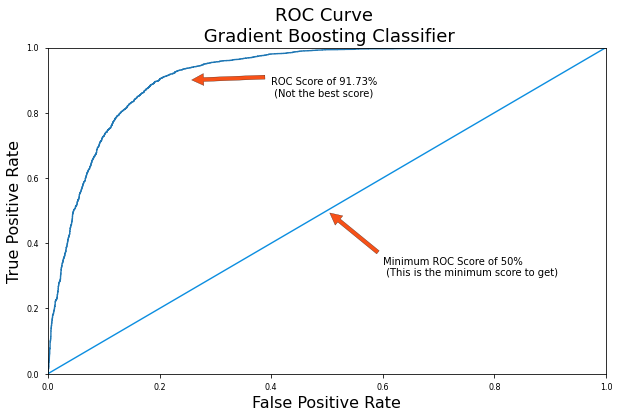

In [44]:
def graph_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.figure(figsize=(10,6))
    plt.title('ROC Curve \n Gradient Boosting Classifier', fontsize=18)
    plt.plot(false_positive_rate, true_positive_rate, label=label)
    plt.plot([0, 1], [0, 1], '#0C8EE0')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('ROC Score of 91.73% \n (Not the best score)', xy=(0.25, 0.9), xytext=(0.4, 0.85),
            arrowprops=dict(facecolor='#F75118', shrink=0.05),
            )
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#F75118', shrink=0.05),
                )
    
    
graph_roc_curve(grd_fpr, grd_tpr, threshold)
plt.show()

In [45]:
from sklearn.metrics import roc_auc_score

print('Gradient Boost Classifier Score: ', roc_auc_score(y_train, y_scores))
print('Neural Classifier Score: ', roc_auc_score(y_train, neural_y_scores))
print('Naives Bayes Classifier: ', roc_auc_score(y_train, naives_y_scores))

Gradient Boost Classifier Score:  0.9173746625867858
Neural Classifier Score:  0.9162909358143174
Naives Bayes Classifier:  0.803352414343226


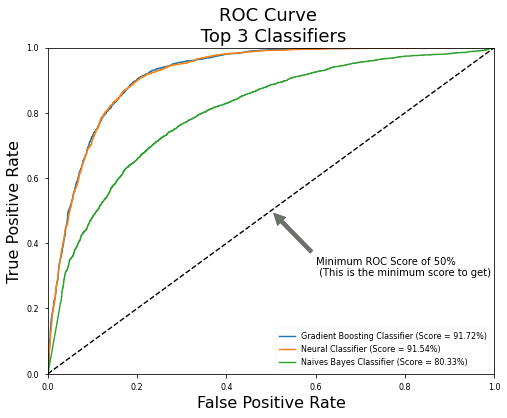

In [46]:
def graph_roc_curve_multiple(grd_fpr, grd_tpr, neu_fpr, neu_tpr, nav_fpr, nav_tpr):
    plt.figure(figsize=(8,6))
    plt.title('ROC Curve \n Top 3 Classifiers', fontsize=18)
    plt.plot(grd_fpr, grd_tpr, label='Gradient Boosting Classifier (Score = 91.72%)')
    plt.plot(neu_fpr, neu_tpr, label='Neural Classifier (Score = 91.54%)')
    plt.plot(nav_fpr, nav_tpr, label='Naives Bayes Classifier (Score = 80.33%)')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(grd_fpr, grd_tpr, neu_fpr, neu_tpr, nav_fpr, nav_tpr)
plt.show()

In [47]:
grad_clf.predict_proba([some_instance])

array([[0.97482622, 0.02517378]])

In [48]:
# Let's see what does our classifier predict.
grad_clf.predict([some_instance]) 

array([0])

In [49]:
y_train[1250]

0

# Which Features Influence the Result of a Term Deposit Suscription?
## DecisionTreeClassifier:
<a id="decision"></a>
The top three most important features for our classifier are **Duration (how long it took the conversation between the sales representative and the potential client), contact (number of contacts to the potential client within the same marketing campaign), month (the month of the year).

Feature ranking:
1. feature 11 (0.591310)
2. feature 8 (0.129966)
3. feature 6 (0.067020)
4. feature 13 (0.049923)
5. feature 15 (0.038138)
6. feature 14 (0.037830)
7. feature 10 (0.026646)
8. feature 5 (0.025842)
9. feature 0 (0.017757)
10. feature 12 (0.007889)
11. feature 3 (0.005280)
12. feature 9 (0.002200)
13. feature 2 (0.000147)
14. feature 1 (0.000050)
15. feature 7 (0.000000)
16. feature 4 (0.000000)


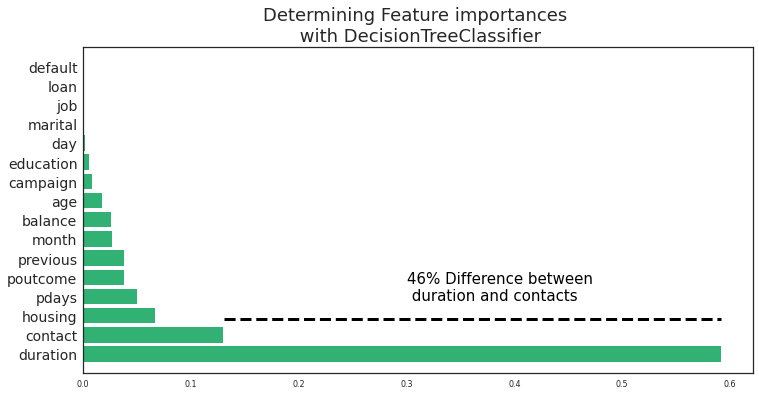

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
plt.style.use('seaborn-white')

# Convert the columns into categorical variables
term_deposits['job'] = term_deposits['job'].astype('category').cat.codes
term_deposits['marital'] = term_deposits['marital'].astype('category').cat.codes
term_deposits['education'] = term_deposits['education'].astype('category').cat.codes
term_deposits['contact'] = term_deposits['contact'].astype('category').cat.codes
term_deposits['poutcome'] = term_deposits['poutcome'].astype('category').cat.codes
term_deposits['month'] = term_deposits['month'].astype('category').cat.codes
term_deposits['default'] = term_deposits['default'].astype('category').cat.codes
term_deposits['loan'] = term_deposits['loan'].astype('category').cat.codes
term_deposits['housing'] = term_deposits['housing'].astype('category').cat.codes

# Let's create new splittings like before but now we modified the data so we need to do it one more time.
# Create train and test splits
target_name = 'deposit'
X = term_deposits.drop('deposit', axis=1)


label=term_deposits[target_name]

X_train, X_test, y_train, y_test = train_test_split(X,label,test_size=0.2, random_state=42, stratify=label)

# Build a classification task using 3 informative features
tree = tree.DecisionTreeClassifier(
    class_weight='balanced',
    min_weight_fraction_leaf = 0.01
    
)



tree = tree.fit(X_train, y_train)
importances = tree.feature_importances_
feature_names = term_deposits.drop('deposit', axis=1).columns
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
def feature_importance_graph(indices, importances, feature_names):
    plt.figure(figsize=(12,6))
    plt.title("Determining Feature importances \n with DecisionTreeClassifier", fontsize=18)
    plt.barh(range(len(indices)), importances[indices], color='#31B173',  align="center")
    plt.yticks(range(len(indices)), feature_names[indices], rotation='horizontal',fontsize=14)
    plt.ylim([-1, len(indices)])
    plt.axhline(y=1.85, xmin=0.21, xmax=0.952, color='k', linewidth=3, linestyle='--')
    plt.text(0.30, 2.8, '46% Difference between \n duration and contacts', color='k', fontsize=15)
    
feature_importance_graph(indices, importances, feature_names)
plt.show()

A voting classifier is a machine learning estimator that trains various base models or estimators and predicts on the basis of aggregating the findings of each base estimator. The aggregating criteria can be combined decision of voting for each estimator output. The voting criteria can be of two types:

* Hard Voting: Voting is calculated on the predicted output class.
* Soft Voting: Voting is calculated on the predicted probability of the output class.

In [51]:
# Our three classifiers are grad_clf, nav_clf and neural_clf
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[('gbc', grad_clf), ('nav', nav_clf), ('neural', neural_clf)],
    voting='soft'
)

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('gbc', GradientBoostingClassifier()),
                             ('nav', GaussianNB()),
                             ('neural', MLPClassifier(alpha=1))],
                 voting='soft')

In [52]:
from sklearn.metrics import accuracy_score

for clf in (grad_clf, nav_clf, neural_clf, voting_clf):
    clf.fit(X_train, y_train)
    predict = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, predict))

GradientBoostingClassifier 0.8463949843260188
GaussianNB 0.7514554411106136
MLPClassifier 0.7536945812807881
VotingClassifier 0.8087774294670846


# <font color="#00bfff"> 5. Conclusion
<a id="5"></a> 
***

**Gradient Boosting** classifier is the best model (84% accuracy) to predict whether or not a potential client will suscribe to a term deposit or not. 


* Focus on specific categories. The model shows that students and senior citizens respond better to proposal.So I would suggest focusing on these two groups and create different financial programs and marketing messages in advertising for each.
* I would recommend creating a marketing campaign for people who didn't have any credits before (explaining how it works and what are the benefits).Recommendations for the Sales Department (Call Center)
* Always contact clients by cellphone when possible
* Target individuals with a higher duration,longer phone conversations perform better, so try to keep a conversation going as much as you can
